In [1]:
import os
import time
import copy
import numpy as np
import pandas as pd
from PIL import Image
import torch,torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets,models,transforms
import torch.optim as optim
# from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from torch.nn import Parameter

In [2]:
# !pip install torchsummary
path='./densenet201/densenet201_3.pth'

In [3]:
from collections.abc import Iterable

def set_freeze_by_idxs(model, idxs, freeze=True): #默认freeze=True是冻结层
    if not isinstance(idxs, Iterable):
        idxs = [idxs]
    num_child = len(list(model.children()))
    idxs = tuple(map(lambda idx: num_child + idx if idx < 0 else idx, idxs))
    for idx, child in enumerate(model.children()):
        if idx not in idxs:
            continue
        for param in child.parameters():
            param.requires_grad = not freeze
    return model
            
def freeze_by_idxs(model, idxs):
    return set_freeze_by_idxs(model, idxs, True)

def unfreeze_by_idxs(model, idxs):
    return set_freeze_by_idxs(model, idxs, False)
def set_parameter_requires_grad(model):#冻结特征提取层
    for param in model.parameters():
        param.requires_grad=False
    return model

def initialize_model(model_name,num_classes,use_pretrained,unfreeze_num):
    if model_name=='vgg16':
        model_pre=models.vgg16(pretrained=use_pretrained) # True：torchversion 已经预训练好的模型，False：随机初始化的模型
#         for i in model_pre.named_children():
#             print(i)
        model_pre.features[0].in_channels=1
        model_pre.features[0].weight=Parameter(model_pre.features[0].weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre) # 冻结全部层
        num_ftrs=model_pre.classifier[6].in_features # feature_map 的大小
        model_pre.classifier[6]=nn.Linear(num_ftrs,num_classes) #重新设计全连接层
        if unfreeze_num==1:
            unfreeze=[-1]
        elif unfreeze_num==2:
            unfreeze=[-1,-3]
        elif unfreeze_num==3:
            unfreeze=[-1,-3,-5]
        else:
            unfreeze=[-1,-3,-5,-7]
        model_pre.features=unfreeze_by_idxs(model_pre.features,unfreeze)
        for param in model_pre.classifier.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='vgg19':
        model_pre=models.vgg19(pretrained=use_pretrained) # True：torchversion 已经预训练好的模型，False：随机初始化的模型
        model_pre.features[0].in_channels=1
        model_pre.features[0].weight=Parameter(model_pre.features[0].weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre) # 冻结全部层
        num_ftrs=model_pre.classifier[6].in_features # feature_map 的大小
        model_pre.classifier[6]=nn.Linear(num_ftrs,num_classes) #重新设计全连接层
        if unfreeze_num==1:
            unfreeze=[-1]
        elif unfreeze_num==2:
            unfreeze=[-1,-3]
        elif unfreeze_num==3:
            unfreeze=[-1,-3,-5]
        else:
            unfreeze=[-1,-3,-5,-7]
        model_pre.features=unfreeze_by_idxs(model_pre.features,unfreeze)
        for param in model_pre.classifier.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='resnet101':
        model_pre=models.resnet101(pretrained=use_pretrained) # True：torchversion 已经预训练好的模型，False：随机初始化的模型
        model_pre.conv1.in_channels=1
        model_pre.conv1.weight=Parameter(model_pre.conv1.weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.fc.in_features # feature_map 的大小
        model_pre.fc=nn.Linear(num_ftrs,num_classes)
        
        for i in range(unfreeze_num):
            model_pre.layer4=unfreeze_by_idxs(model_pre.layer4,-i)
        for param in model_pre.fc.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='resnet152':
        model_pre=models.resnet152(pretrained=use_pretrained) #True：torchversion 已经预训练好的模型，False：随机初始化的模型
        model_pre.conv1.in_channels=1
        model_pre.conv1.weight=Parameter(model_pre.conv1.weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.fc.in_features #feature_map 的大小
        model_pre.fc=nn.Linear(num_ftrs,num_classes)

        for i in range(unfreeze_num):
            model_pre.layer4=unfreeze_by_idxs(model_pre.layer4,-i)
        for param in model_pre.fc.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='densenet161':
        model_pre=models.densenet161(pretrained=use_pretrained) #True：torchversion 已经预训练好的模型，False：随机初始化的模型
        model_pre.features[0].in_channels=1
        model_pre.features[0].weight=Parameter(model_pre.features[0].weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.classifier.in_features #feature_map 的大小
        model_pre.classifier=nn.Linear(num_ftrs,num_classes)
        
        for i in range(unfreeze_num):
            model_pre.features.denseblock4=unfreeze_by_idxs(model_pre.features.denseblock4,-i)
        for param in model_pre.classifier.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='densenet201':
        model_pre=models.densenet201(pretrained=use_pretrained) #True：torchversion 已经预训练好的模型，False：随机初始化的模型
        model_pre.features[0].in_channels=1
        model_pre.features[0].weight=Parameter(model_pre.features[0].weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.classifier.in_features #feature_map 的大小
        model_pre.classifier=nn.Linear(num_ftrs,num_classes)
        
        for i in range(unfreeze_num):
            model_pre.features.denseblock4=unfreeze_by_idxs(model_pre.features.denseblock4,-i)
        for param in model_pre.classifier.parameters():
            param.requires_grad=True
        input_size=224
    else:
        print('model not implemented')
        return None,None
    return model_pre,input_size

In [4]:
from pathlib import Path
model_all=[]
dir='.'
def auto_net(model_name,num_classes,use_pretrained,unfreeze_num):
    
    for k in range(unfreeze_num):
        model,input_size=initialize_model(model_name,num_classes,use_pretrained,k+1)
        my_path=Path(dir+'/{}'.format(model_name))
        if not my_path.is_dir():    # 若指定的目录不存在，创建文件夹
            os.mkdir(my_path)
        torch.save(model,dir+'/{}/{}_{}.pth'.format(model_name,model_name,k)) # 0 1 2 3
            
        model_all.append(model)
#         print('------------------------删除{}层,添加{}层,倒数{}层求梯度------------------------'.format(i+1,j+1,k+1))
#         for m in model.named_children():
#             print(m)
#         print('----------------')
#         for n in model.named_parameters():
#             print(n)
    return model_all
model_name=['vgg16','vgg19','resnet101','resnet152','densenet161','densenet201'] # 'inception_v3','resnext101'
# for name in model_name:
#     model_all=auto_net(name,num_classes=2,use_pretrained=True,unfreeze_num=4)
model_all=auto_net(model_name[5],num_classes=3,use_pretrained=True,unfreeze_num=4)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

In [5]:
# 读取train.txt
train_df = pd.read_csv('../input/covidxct/train_COVIDx_CT-2A.txt', sep=" ", header=None)
train_df.columns=['filename', 'label', 'xmin','ymin','xmax','ymax']
train_df=train_df.drop(['xmin', 'ymin','xmax', 'ymax'], axis=1 )
# 读取test.txt
val_df = pd.read_csv('../input/covidxct/val_COVIDx_CT-2A.txt', sep=" ", header=None)
val_df.columns=['filename', 'label', 'xmin','ymin','xmax','ymax']
val_df=val_df.drop(['xmin', 'ymin','xmax', 'ymax'], axis=1 )

test_df = pd.read_csv('../input/covidxct/test_COVIDx_CT-2A.txt', sep=" ", header=None)
test_df.columns=['filename', 'label', 'xmin','ymin','xmax','ymax']
test_df=test_df.drop(['xmin', 'ymin','xmax', 'ymax'], axis=1 )

In [6]:
# labels={0:'Normal',1:'Pneumonia',2:'COVID-19'}
train_df.head()
train_df.label.value_counts()

2    82286
0    35996
1    25496
Name: label, dtype: int64

In [7]:
image_path = '../input/covidxct/2A_images/'  #directory path
train_df['filename'] = image_path+train_df['filename']
val_df['filename'] = image_path+val_df['filename']
test_df['filename'] = image_path + test_df['filename']
train_df.head()

,filename,label
0,../input/covidxct/2A_images/NCP_96_1328_0032.png,2
1,../input/covidxct/2A_images/NCP_96_1328_0035.png,2
2,../input/covidxct/2A_images/NCP_96_1328_0036.png,2
3,../input/covidxct/2A_images/NCP_96_1328_0037.png,2
4,../input/covidxct/2A_images/NCP_96_1328_0038.png,2


In [8]:
N  = train_df[train_df['label']==0]
P = train_df[train_df['label']==1]
C = train_df[train_df['label']==2]
from sklearn.utils import resample
N_download = resample(N, replace = True, n_samples = 25496,random_state=0)
C_download = resample(C, replace = True, n_samples = 25496,random_state=0)
train_df = pd.concat([N_download, P, C_download])
train_df.label.value_counts()

2    25496
1    25496
0    25496
Name: label, dtype: int64

In [9]:
N_v  = val_df[val_df['label']==0]
P_v = val_df[val_df['label']==1]
C_v = val_df[val_df['label']==2]
from sklearn.utils import resample
N_v_download = resample(N_v, replace = True, n_samples = 6244,random_state=0)
P_v_download = resample(P_v, replace = True, n_samples = 6244,random_state=0)
val_df = pd.concat([N_v_download, P_v_download, C_v])
val_df.label.value_counts()

2    6244
1    6244
0    6244
Name: label, dtype: int64

In [10]:
train_df = shuffle(train_df) # 打乱顺序
val_df = shuffle(val_df)
test_df = shuffle(test_df)
train_df.head()

,filename,label
55592,../input/covidxct/2A_images/Normal_3913_5455_0...,0
34770,../input/covidxct/2A_images/Normal_1742_1055_0...,0
136993,../input/covidxct/2A_images/HUST-Patient777-00...,2
108873,../input/covidxct/2A_images/HUST-Patient1344-0...,2
5889,../input/covidxct/2A_images/NCP_450_2055_0014.png,2


In [11]:
labels={0:'Normal',1:'Pneumonia',2:'COVID-19'}
class_names=['Normal','Pneumonia','COVID-19']

train_df['label_n']=[labels[b] for b in train_df['label']]
val_df['label_n']=[labels[b] for b in val_df['label']]
test_df['label_n']=[labels[b] for b in test_df['label']]
train_df.head()

,filename,label,label_n
55592,../input/covidxct/2A_images/Normal_3913_5455_0...,0,Normal
34770,../input/covidxct/2A_images/Normal_1742_1055_0...,0,Normal
136993,../input/covidxct/2A_images/HUST-Patient777-00...,2,COVID-19
108873,../input/covidxct/2A_images/HUST-Patient1344-0...,2,COVID-19
5889,../input/covidxct/2A_images/NCP_450_2055_0014.png,2,COVID-19


In [12]:
print(f"Negative and positive values of train: \n{train_df['label_n'].value_counts()}")
print(f"Negative and positive values of validation: \n{val_df['label_n'].value_counts()}")
print(f"Negative and positive values of test: \n{test_df['label_n'].value_counts()}")

Negative and positive values of train: 
Normal       25496
Pneumonia    25496
COVID-19     25496
Name: label_n, dtype: int64
Negative and positive values of validation: 
Normal       6244
Pneumonia    6244
COVID-19     6244
Name: label_n, dtype: int64
Negative and positive values of test: 
Normal       12245
Pneumonia     7395
COVID-19      6018
Name: label_n, dtype: int64


In [13]:
train_df=train_df.reset_index()
val_df=val_df.reset_index()
test_df=test_df.reset_index()

In [14]:
class CovidDataset(Dataset):
    def __init__(self, dataset_df, transform=None):
        self.dataset_df = dataset_df
        self.transform = transform
        
    def __len__(self):
        return self.dataset_df.shape[0]
    
    def __getitem__(self, idx):
        image_name = self.dataset_df['filename'][idx]
        img = Image.open(image_name)
        label = self.dataset_df['label'][idx]
        
        if self.transform:
            img = self.transform(img)
        return img, label

In [15]:
batch_size = 64
input_channel = 1
input_size = (224,224)
crop_size=(340,380)
num_classes=3
num_epochs = 20

In [16]:
transform = {
    'train':transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.CenterCrop(crop_size),
        transforms.Resize(input_size),
        transforms.Grayscale(input_channel),
        transforms.ToTensor(),
        transforms.Normalize([0.6349431],[0.32605055])
    ]),
    'test':transforms.Compose([
        transforms.CenterCrop(crop_size),
        transforms.Resize(input_size),
        transforms.Grayscale(input_channel),
        transforms.ToTensor(),
        transforms.Normalize([0.63507175],[0.3278614])
    ])
}

In [17]:
dataset_names=['train','val','test']
image_transforms = {'train':transform['train'], 'val':transform['test'],'test':transform['test']}

train_dataset = CovidDataset(train_df, transform=image_transforms['train'])
val_dataset = CovidDataset(val_df, transform=image_transforms['val'])
test_dataset = CovidDataset(test_df, transform=image_transforms['test'])

image_dataset = {'train':train_dataset, 'val':val_dataset,'test':test_dataset}

dataloaders = {x:DataLoader(image_dataset[x],batch_size=batch_size,shuffle=True,num_workers=4) for x in dataset_names}

dataset_sizes = {x:len(image_dataset[x]) for x in dataset_names}

# class_names = {}
# print(dataset_sizes)
# print(class_names)

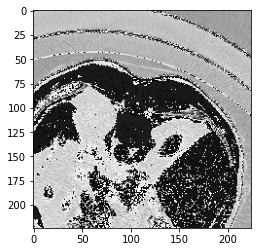

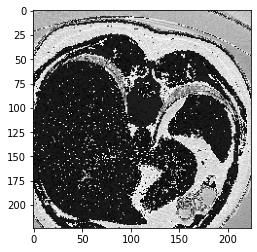

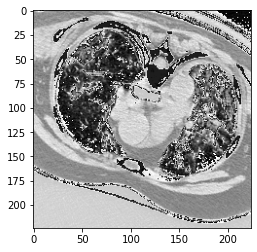

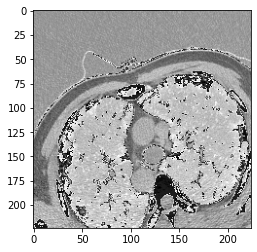

In [18]:
import matplotlib.pyplot as plt
from PIL import Image
def show_tensor_img(tensor_img):
#     to_pil = transforms.ToPILImage()
#     img = tensor_img.cpu().clone()
#     img = to_pil(img)
    img=transforms.ToPILImage()(tensor_img)
    plt.figure()
    plt.imshow(img,plt.cm.gray)
    plt.show()

def show_img(idx):
  show_tensor_img(train_dataset[idx][0])
for i in range(4):
    show_img(i)

In [19]:
# def get_mean_std(dataset, ratio=0.01): # 计算样本的均值与方差
#     """Get mean and std by sample ratio
#     """
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio),shuffle=True, num_workers=2)
#     train = iter(dataloader).next()[0]   # 一个batch的数据
# #     print(train)
#     mean = np.mean(train.numpy(), axis=(0,2,3))
#     std = np.std(train.numpy(), axis=(0,2,3))
#     return mean, std
# train_mean, train_std = get_mean_std(train_dataset)
# val_mean, val_std = get_mean_std(val_dataset)
# test_mean, test_std = get_mean_std(test_dataset)

# print(train_mean, train_std)
# print(val_mean, val_std)
# print(test_mean,test_std)

In [20]:
import itertools
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    cm=cm.numpy()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        cm=cm.astype('int')
        print('Confusion matrix, without normalization')
#     print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '{:.2f}' if normalize else '{}'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(i, j, fmt.format(cm[i, j]),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 生成混淆矩阵
def confusion_matrix(preds, labels, conf_matrix):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        conf_matrix[t, p] += 1
    return conf_matrix

def calculate_all_prediction(conf_matrix):
    '''
    计算总精度：对角线上所有值除以总数
    '''
    total_sum = conf_matrix.sum()
    correct_sum = (np.diag(conf_matrix)).sum()
    prediction = round(100*float(correct_sum)/float(total_sum),2)
    return prediction
 
def calculate_label_prediction(conf_matrix,labelidx):
    '''
    计算某一个类标预测精度：该类被预测正确的数除以该类的总数
    '''
    label_total_sum = conf_matrix.sum(axis=0)[labelidx]
    label_correct_sum = conf_matrix[labelidx][labelidx]
    prediction = 0
    if label_total_sum != 0:
        prediction = round(100*float(label_correct_sum)/float(label_total_sum),2)
    return prediction
 
def calculate_label_recall(conf_matrix,labelidx):
    '''
    计算某一个类标的召回率：
    '''
    label_total_sum = conf_matrix.sum(axis=1)[labelidx]
    label_correct_sum = conf_matrix[labelidx][labelidx]
    recall = 0
    if label_total_sum != 0:
        recall = round(100*float(label_correct_sum)/float(label_total_sum),2)
    return recall
 
def calculate_f1(prediction,recall):
    if (prediction+recall)==0:
        return 0
    return round(2*prediction*recall/(prediction+recall),2)


In [21]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# path='./vgg16/vgg16_1.pth'
model=torch.load(path)
model=model.to(device)
# print(model)

# model=models.vgg16(pretrained=True)
# # 将所有参数都设置为不计算梯度
# for param in model.parameters():
#     param.requires_grad=False
# num_ftrs=model.classifier[6].in_features # feature_map 的大小
# model.classifier[6]=nn.Linear(num_ftrs,num_classes) #重新设计全连接层
# model=model.to(device)

criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,betas=(0.9, 0.999)) #优化函数

In [22]:
def train(model,epoch,num_epochs,criterion,optimizer):
    model.train()
    print('-' * 100)
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    running_loss = 0.0
    running_corrects = 0
    for idx, (inputs, labels) in enumerate(dataloaders['train']):# 对dataloader进行遍历，dataloader时包含数据及标签的元组
        inputs,labels=inputs.to(device),labels.to(device)
        outputs = model(inputs) # output接受结果
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)  # 默认平均，计算损失值

        #反向传播及更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % 100 == 99:
            print('train iteration:{},loss:{},acc:{}%'.format( idx, loss.item(),torch.sum(preds == labels.data)/batch_size*100))
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']
    print('train_total Loss: {:.4f} Acc: {:.4f}%'.format( epoch_loss, epoch_acc*100))

In [23]:
def test(model,epoch,num_epochs,criterion,optimizer,best_acc):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    best_acc=best_acc
    best_model_wts=copy.deepcopy(model.state_dict())
    conf_matrix = torch.zeros(num_classes, num_classes) # 混淆矩阵初始化
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders['val']):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            conf_matrix = confusion_matrix(outputs, labels, conf_matrix) # 生成混淆矩阵

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data) #preds是tensor,labels.data是tensor

        plot_confusion_matrix(conf_matrix, classes=class_names, normalize=False, title='confusion matrix') # 混淆矩阵的可视化

    epoch_loss = running_loss / dataset_sizes['val'] 
    epoch_acc = running_corrects.double() / dataset_sizes['val'] #type为tensor
    print('val_total Loss: {:.4f} Acc: {:.4f}%'.format( epoch_loss, epoch_acc*100))

    all_prediction = calculate_all_prediction(conf_matrix) # 总精度=准确率
    print('all_prediction:{}'.format(all_prediction))
    label_prediction = [] # 存放每个类的精确率
    label_recall = [] # 存放每个类的召回率
    for i in range(num_classes):
        label_prediction.append(calculate_label_prediction(conf_matrix,i))
        label_recall.append(calculate_label_recall(conf_matrix,i))

    keys=class_names
    values=list(range(num_classes))
    dictionary = dict(zip(keys, values))
    for ei,i in enumerate(dictionary):
        print(ei,'\t',i,'\t','prediction=',label_prediction[ei],'%,\trecall=',label_recall[ei],'%,\tf1=',calculate_f1(label_prediction[ei],label_recall[ei])) # 输出每个类的，精确率，召回率，F1
    p = round(np.array(label_prediction).sum()/len(label_prediction),2) # 总精确率
    r = round(np.array(label_recall).sum()/len(label_prediction),2) # 总召回率
    print('MACRO-averaged:\nprediction=',p,'%,recall=',r,'%,f1=',calculate_f1(p,r)) #输出总精确率和召回率

#     print(epoch_acc.tpye)
#     print(best_acc.type)
    if epoch_acc > best_acc:# 获取最好的模型和准确率
        best_acc=epoch_acc.item()
        best_model_wts=copy.deepcopy(model.state_dict())
#     model.load_state_dict(best_model_wts)

    return best_model_wts,best_acc,epoch_acc.item()

----------------------------------------------------------------------------------------------------
Epoch 0/19
train iteration:99,loss:0.33409959077835083,acc:96.875%
train iteration:199,loss:0.26115986704826355,acc:93.75%
train iteration:299,loss:0.11175686866044998,acc:96.875%
train iteration:399,loss:0.13428176939487457,acc:95.3125%
train iteration:499,loss:0.11228672415018082,acc:98.4375%
train iteration:599,loss:0.07767551392316818,acc:96.875%
train iteration:699,loss:0.13022860884666443,acc:95.3125%
train iteration:799,loss:0.061806000769138336,acc:96.875%
train iteration:899,loss:0.09681377559900284,acc:96.875%
train iteration:999,loss:0.09626156091690063,acc:95.3125%
train iteration:1099,loss:0.01800590008497238,acc:100.0%
train_total Loss: 0.1634 Acc: 95.3444%
Confusion matrix, without normalization


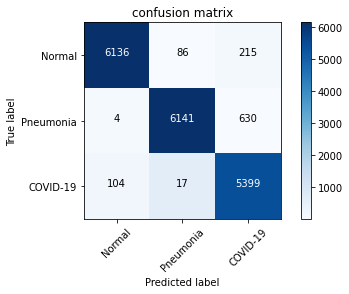

val_total Loss: 0.1722 Acc: 94.3626%
all_prediction:94.36
0 	 Normal 	 prediction= 95.32 %,	recall= 98.27 %,	f1= 96.77
1 	 Pneumonia 	 prediction= 90.64 %,	recall= 98.35 %,	f1= 94.34
2 	 COVID-19 	 prediction= 97.81 %,	recall= 86.47 %,	f1= 91.79
MACRO-averaged:
prediction= 94.59 %,recall= 94.36 %,f1= 94.47
----------------------------------------------------------------------------------------------------
Epoch 1/19
train iteration:99,loss:0.054462332278490067,acc:96.875%
train iteration:199,loss:0.039280541241168976,acc:100.0%
train iteration:299,loss:0.0638398751616478,acc:98.4375%
train iteration:399,loss:0.038113225251436234,acc:100.0%
train iteration:499,loss:0.034725263714790344,acc:100.0%
train iteration:599,loss:0.038787227123975754,acc:96.875%
train iteration:699,loss:0.012466575019061565,acc:100.0%
train iteration:799,loss:0.025812918320298195,acc:100.0%
train iteration:899,loss:0.020684342831373215,acc:98.4375%
train iteration:999,loss:0.01545112393796444,acc:100.0%
train it

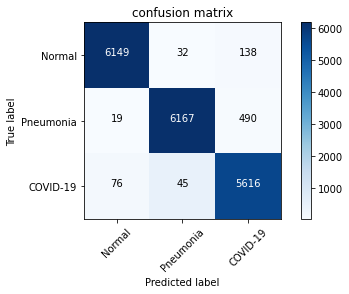

val_total Loss: 0.1646 Acc: 95.7292%
all_prediction:95.73
0 	 Normal 	 prediction= 97.31 %,	recall= 98.48 %,	f1= 97.89
1 	 Pneumonia 	 prediction= 92.38 %,	recall= 98.77 %,	f1= 95.47
2 	 COVID-19 	 prediction= 97.89 %,	recall= 89.94 %,	f1= 93.75
MACRO-averaged:
prediction= 95.86 %,recall= 95.73 %,f1= 95.79
----------------------------------------------------------------------------------------------------
Epoch 2/19
train iteration:99,loss:0.025780756026506424,acc:98.4375%
train iteration:199,loss:0.06635864078998566,acc:98.4375%
train iteration:299,loss:0.042349621653556824,acc:98.4375%
train iteration:399,loss:0.005608727689832449,acc:100.0%
train iteration:499,loss:0.03188609704375267,acc:100.0%
train iteration:599,loss:0.04011736437678337,acc:98.4375%
train iteration:699,loss:0.017146766185760498,acc:100.0%
train iteration:799,loss:0.07613097876310349,acc:96.875%
train iteration:899,loss:0.06060623377561569,acc:98.4375%
train iteration:999,loss:0.04621347412467003,acc:98.4375%
trai

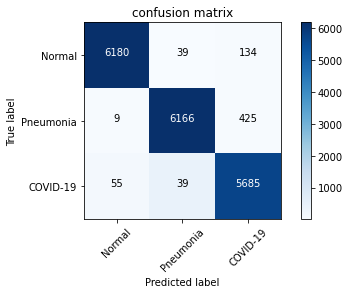

val_total Loss: 0.1492 Acc: 96.2577%
all_prediction:96.26
0 	 Normal 	 prediction= 97.28 %,	recall= 98.98 %,	f1= 98.12
1 	 Pneumonia 	 prediction= 93.42 %,	recall= 98.75 %,	f1= 96.01
2 	 COVID-19 	 prediction= 98.37 %,	recall= 91.05 %,	f1= 94.57
MACRO-averaged:
prediction= 96.36 %,recall= 96.26 %,f1= 96.31
----------------------------------------------------------------------------------------------------
Epoch 3/19
train iteration:99,loss:0.02255922183394432,acc:98.4375%
train iteration:199,loss:0.08169989287853241,acc:96.875%
train iteration:299,loss:0.06814117729663849,acc:98.4375%
train iteration:399,loss:0.014815823175013065,acc:100.0%
train iteration:499,loss:0.011135726235806942,acc:100.0%
train iteration:599,loss:0.010109919123351574,acc:100.0%
train iteration:699,loss:0.009697459638118744,acc:100.0%
train iteration:799,loss:0.036698177456855774,acc:96.875%
train iteration:899,loss:0.010471104644238949,acc:100.0%
train iteration:999,loss:0.00764806754887104,acc:100.0%
train ite

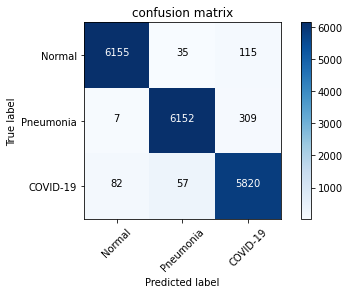

val_total Loss: 0.1041 Acc: 96.7702%
all_prediction:96.77
0 	 Normal 	 prediction= 97.62 %,	recall= 98.57 %,	f1= 98.09
1 	 Pneumonia 	 prediction= 95.11 %,	recall= 98.53 %,	f1= 96.79
2 	 COVID-19 	 prediction= 97.67 %,	recall= 93.21 %,	f1= 95.39
MACRO-averaged:
prediction= 96.8 %,recall= 96.77 %,f1= 96.78
----------------------------------------------------------------------------------------------------
Epoch 4/19
train iteration:99,loss:0.037470001727342606,acc:98.4375%
train iteration:199,loss:0.04258468747138977,acc:98.4375%
train iteration:299,loss:0.005218947306275368,acc:100.0%
train iteration:399,loss:0.0014908326556906104,acc:100.0%
train iteration:499,loss:0.007584645878523588,acc:100.0%
train iteration:599,loss:0.02667304500937462,acc:98.4375%
train iteration:699,loss:0.0038106257561594248,acc:100.0%
train iteration:799,loss:0.01158392708748579,acc:100.0%
train iteration:899,loss:0.0124305859208107,acc:100.0%
train iteration:999,loss:0.004048609174787998,acc:100.0%
train ite

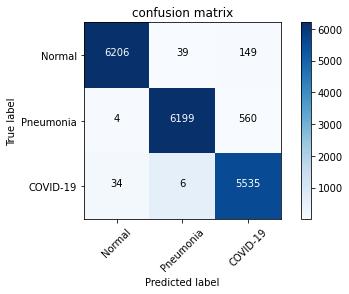

val_total Loss: 0.2107 Acc: 95.7719%
all_prediction:95.77
0 	 Normal 	 prediction= 97.06 %,	recall= 99.39 %,	f1= 98.21
1 	 Pneumonia 	 prediction= 91.66 %,	recall= 99.28 %,	f1= 95.32
2 	 COVID-19 	 prediction= 99.28 %,	recall= 88.65 %,	f1= 93.66
MACRO-averaged:
prediction= 96.0 %,recall= 95.77 %,f1= 95.88
----------------------------------------------------------------------------------------------------
Epoch 5/19
train iteration:99,loss:0.0003646938712336123,acc:100.0%
train iteration:199,loss:0.015901613980531693,acc:98.4375%
train iteration:299,loss:0.005838099401444197,acc:100.0%
train iteration:399,loss:0.017987435683608055,acc:98.4375%
train iteration:499,loss:0.002163575729355216,acc:100.0%
train iteration:599,loss:0.01497626956552267,acc:98.4375%
train iteration:699,loss:0.006306623108685017,acc:100.0%
train iteration:799,loss:0.008554753847420216,acc:100.0%
train iteration:899,loss:0.032686181366443634,acc:98.4375%
train iteration:999,loss:0.010530710220336914,acc:100.0%
trai

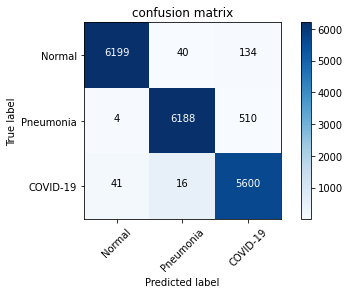

val_total Loss: 0.1987 Acc: 96.0228%
all_prediction:96.02
0 	 Normal 	 prediction= 97.27 %,	recall= 99.28 %,	f1= 98.26
1 	 Pneumonia 	 prediction= 92.33 %,	recall= 99.1 %,	f1= 95.6
2 	 COVID-19 	 prediction= 98.99 %,	recall= 89.69 %,	f1= 94.11
MACRO-averaged:
prediction= 96.2 %,recall= 96.02 %,f1= 96.11
----------------------------------------------------------------------------------------------------
Epoch 6/19
train iteration:99,loss:0.002234172308817506,acc:100.0%
train iteration:199,loss:0.028875958174467087,acc:98.4375%
train iteration:299,loss:0.0016975144390016794,acc:100.0%
train iteration:399,loss:0.012051915749907494,acc:100.0%
train iteration:499,loss:0.0034500521142035723,acc:100.0%
train iteration:599,loss:0.14350248873233795,acc:93.75%
train iteration:699,loss:0.01361074484884739,acc:100.0%
train iteration:799,loss:0.023107275366783142,acc:98.4375%
train iteration:899,loss:0.028352342545986176,acc:100.0%
train iteration:999,loss:0.00826667994260788,acc:100.0%
train itera

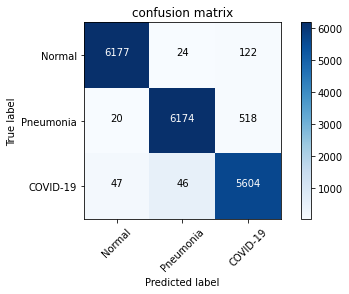

val_total Loss: 0.2068 Acc: 95.8520%
all_prediction:95.85
0 	 Normal 	 prediction= 97.69 %,	recall= 98.93 %,	f1= 98.31
1 	 Pneumonia 	 prediction= 91.98 %,	recall= 98.88 %,	f1= 95.31
2 	 COVID-19 	 prediction= 98.37 %,	recall= 89.75 %,	f1= 93.86
MACRO-averaged:
prediction= 96.01 %,recall= 95.85 %,f1= 95.93
----------------------------------------------------------------------------------------------------
Epoch 7/19
train iteration:99,loss:0.01751857064664364,acc:100.0%
train iteration:199,loss:0.0038188653998076916,acc:100.0%
train iteration:299,loss:0.0448974147439003,acc:98.4375%
train iteration:399,loss:0.04459096118807793,acc:98.4375%
train iteration:499,loss:0.002655354328453541,acc:100.0%
train iteration:599,loss:0.0033612854313105345,acc:100.0%
train iteration:699,loss:0.005918627139180899,acc:100.0%
train iteration:799,loss:0.053932495415210724,acc:98.4375%
train iteration:899,loss:0.011222444474697113,acc:100.0%
train iteration:999,loss:0.0020305607467889786,acc:100.0%
train 

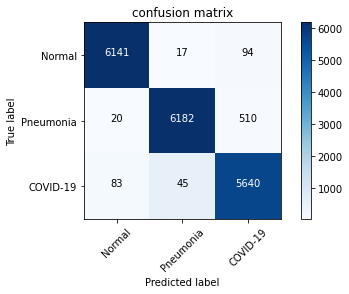

val_total Loss: 0.1941 Acc: 95.8947%
all_prediction:95.89
0 	 Normal 	 prediction= 98.22 %,	recall= 98.35 %,	f1= 98.28
1 	 Pneumonia 	 prediction= 92.1 %,	recall= 99.01 %,	f1= 95.43
2 	 COVID-19 	 prediction= 97.78 %,	recall= 90.33 %,	f1= 93.91
MACRO-averaged:
prediction= 96.03 %,recall= 95.9 %,f1= 95.96
----------------------------------------------------------------------------------------------------
Epoch 8/19
train iteration:99,loss:0.002402388956397772,acc:100.0%
train iteration:199,loss:0.003415418555960059,acc:100.0%
train iteration:299,loss:0.0009758338565006852,acc:100.0%
train iteration:399,loss:0.03662807494401932,acc:96.875%
train iteration:499,loss:0.0003074242558795959,acc:100.0%
train iteration:599,loss:0.0022301680874079466,acc:100.0%
train iteration:699,loss:0.0021656916942447424,acc:100.0%
train iteration:799,loss:0.0008894652710296214,acc:100.0%
train iteration:899,loss:0.0035369861871004105,acc:100.0%
train iteration:999,loss:0.014689665287733078,acc:100.0%
train i

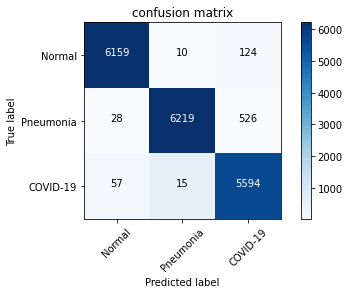

val_total Loss: 0.2314 Acc: 95.9428%
all_prediction:95.94
0 	 Normal 	 prediction= 97.87 %,	recall= 98.64 %,	f1= 98.25
1 	 Pneumonia 	 prediction= 91.82 %,	recall= 99.6 %,	f1= 95.55
2 	 COVID-19 	 prediction= 98.73 %,	recall= 89.59 %,	f1= 93.94
MACRO-averaged:
prediction= 96.14 %,recall= 95.94 %,f1= 96.04
----------------------------------------------------------------------------------------------------
Epoch 9/19
train iteration:99,loss:0.004944010637700558,acc:100.0%
train iteration:199,loss:0.005772995762526989,acc:100.0%
train iteration:299,loss:0.006665161810815334,acc:100.0%
train iteration:399,loss:0.0006126784719526768,acc:100.0%
train iteration:499,loss:0.010330685414373875,acc:100.0%
train iteration:599,loss:0.0014220805605873466,acc:100.0%
train iteration:699,loss:0.013629332184791565,acc:100.0%
train iteration:799,loss:0.0009441907750442624,acc:100.0%
train iteration:899,loss:0.002283854177221656,acc:100.0%
train iteration:999,loss:0.001956102205440402,acc:100.0%
train ite

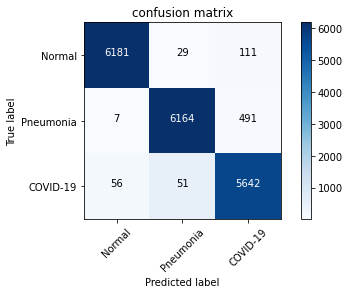

val_total Loss: 0.1960 Acc: 96.0228%
all_prediction:96.02
0 	 Normal 	 prediction= 97.79 %,	recall= 98.99 %,	f1= 98.39
1 	 Pneumonia 	 prediction= 92.52 %,	recall= 98.72 %,	f1= 95.52
2 	 COVID-19 	 prediction= 98.14 %,	recall= 90.36 %,	f1= 94.09
MACRO-averaged:
prediction= 96.15 %,recall= 96.02 %,f1= 96.08
----------------------------------------------------------------------------------------------------
Epoch 10/19
train iteration:99,loss:0.01607622392475605,acc:100.0%
train iteration:199,loss:0.0029818611219525337,acc:100.0%
train iteration:299,loss:0.00405433913692832,acc:100.0%
train iteration:399,loss:0.007127446588128805,acc:100.0%
train iteration:499,loss:0.06927049905061722,acc:96.875%
train iteration:599,loss:0.001229985267855227,acc:100.0%
train iteration:699,loss:0.015510489232838154,acc:98.4375%
train iteration:799,loss:0.002200573915615678,acc:100.0%
train iteration:899,loss:0.0015732173342257738,acc:100.0%
train iteration:999,loss:0.002997596049681306,acc:100.0%
train it

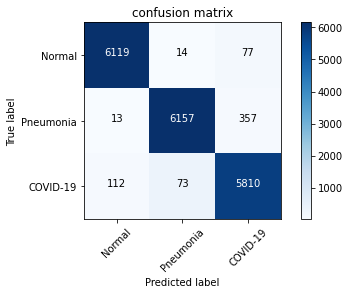

val_total Loss: 0.1435 Acc: 96.5514%
all_prediction:96.55
0 	 Normal 	 prediction= 98.53 %,	recall= 98.0 %,	f1= 98.26
1 	 Pneumonia 	 prediction= 94.33 %,	recall= 98.61 %,	f1= 96.42
2 	 COVID-19 	 prediction= 96.91 %,	recall= 93.05 %,	f1= 94.94
MACRO-averaged:
prediction= 96.59 %,recall= 96.55 %,f1= 96.57
----------------------------------------------------------------------------------------------------
Epoch 11/19
train iteration:99,loss:0.04179352521896362,acc:98.4375%
train iteration:199,loss:0.007815816439688206,acc:100.0%
train iteration:299,loss:0.0005560244899243116,acc:100.0%
train iteration:399,loss:0.0007866733940318227,acc:100.0%
train iteration:499,loss:0.026439080014824867,acc:98.4375%
train iteration:599,loss:0.0012520174495875835,acc:100.0%
train iteration:699,loss:0.02926345355808735,acc:98.4375%
train iteration:799,loss:0.004564961418509483,acc:100.0%
train iteration:899,loss:0.0014660359593108296,acc:100.0%
train iteration:999,loss:0.002450115978717804,acc:100.0%
tra

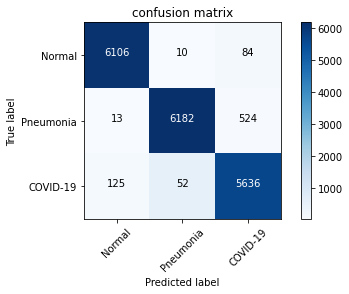

val_total Loss: 0.2238 Acc: 95.6865%
all_prediction:95.69
0 	 Normal 	 prediction= 98.48 %,	recall= 97.79 %,	f1= 98.13
1 	 Pneumonia 	 prediction= 92.01 %,	recall= 99.01 %,	f1= 95.38
2 	 COVID-19 	 prediction= 96.96 %,	recall= 90.26 %,	f1= 93.49
MACRO-averaged:
prediction= 95.82 %,recall= 95.69 %,f1= 95.75
----------------------------------------------------------------------------------------------------
Epoch 12/19
train iteration:99,loss:0.00237618968822062,acc:100.0%
train iteration:199,loss:0.0009658934432081878,acc:100.0%
train iteration:299,loss:0.004297226667404175,acc:100.0%
train iteration:399,loss:0.0013195706997066736,acc:100.0%
train iteration:499,loss:0.01834174059331417,acc:98.4375%
train iteration:599,loss:0.00361240329220891,acc:100.0%
train iteration:699,loss:0.012788454070687294,acc:100.0%
train iteration:799,loss:0.0020556296221911907,acc:100.0%
train iteration:899,loss:0.013348364271223545,acc:98.4375%
train iteration:999,loss:0.031686101108789444,acc:98.4375%
trai

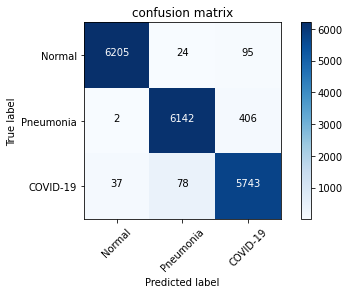

val_total Loss: 0.1635 Acc: 96.5727%
all_prediction:96.57
0 	 Normal 	 prediction= 98.12 %,	recall= 99.38 %,	f1= 98.75
1 	 Pneumonia 	 prediction= 93.77 %,	recall= 98.37 %,	f1= 96.01
2 	 COVID-19 	 prediction= 98.04 %,	recall= 91.98 %,	f1= 94.91
MACRO-averaged:
prediction= 96.64 %,recall= 96.58 %,f1= 96.61
----------------------------------------------------------------------------------------------------
Epoch 13/19
train iteration:99,loss:0.014607074670493603,acc:100.0%
train iteration:199,loss:0.0033944062888622284,acc:100.0%
train iteration:299,loss:0.0011084297439083457,acc:100.0%
train iteration:399,loss:0.003464825451374054,acc:100.0%
train iteration:499,loss:0.0005985398893244565,acc:100.0%
train iteration:599,loss:0.0046362848952412605,acc:100.0%
train iteration:699,loss:0.00449414411559701,acc:100.0%
train iteration:799,loss:0.012611900456249714,acc:98.4375%
train iteration:899,loss:0.0004931723815388978,acc:100.0%
train iteration:999,loss:0.001316585810855031,acc:100.0%
trai

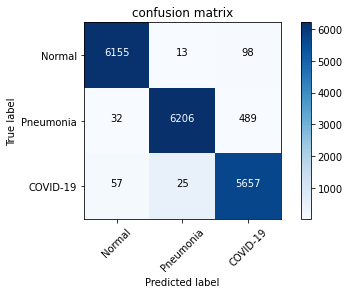

val_total Loss: 0.1959 Acc: 96.1883%
all_prediction:96.19
0 	 Normal 	 prediction= 98.23 %,	recall= 98.57 %,	f1= 98.4
1 	 Pneumonia 	 prediction= 92.26 %,	recall= 99.39 %,	f1= 95.69
2 	 COVID-19 	 prediction= 98.57 %,	recall= 90.6 %,	f1= 94.42
MACRO-averaged:
prediction= 96.35 %,recall= 96.19 %,f1= 96.27
----------------------------------------------------------------------------------------------------
Epoch 14/19
train iteration:99,loss:0.00604161387309432,acc:100.0%
train iteration:199,loss:0.0016931050922721624,acc:100.0%
train iteration:299,loss:0.005075568798929453,acc:100.0%
train iteration:399,loss:0.0017744532087817788,acc:100.0%
train iteration:499,loss:0.000945914420299232,acc:100.0%
train iteration:599,loss:0.00019566432456485927,acc:100.0%
train iteration:699,loss:0.01651923917233944,acc:100.0%
train iteration:799,loss:0.001777337514795363,acc:100.0%
train iteration:899,loss:0.0007529827998951077,acc:100.0%
train iteration:999,loss:0.000792051141615957,acc:100.0%
train ite

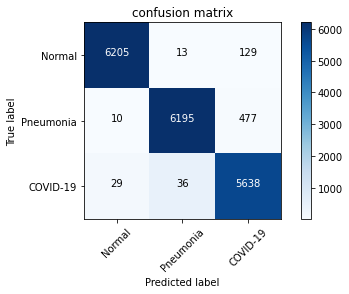

val_total Loss: 0.1970 Acc: 96.2951%
all_prediction:96.3
0 	 Normal 	 prediction= 97.76 %,	recall= 99.38 %,	f1= 98.56
1 	 Pneumonia 	 prediction= 92.71 %,	recall= 99.22 %,	f1= 95.85
2 	 COVID-19 	 prediction= 98.86 %,	recall= 90.29 %,	f1= 94.38
MACRO-averaged:
prediction= 96.44 %,recall= 96.3 %,f1= 96.37
----------------------------------------------------------------------------------------------------
Epoch 15/19
train iteration:99,loss:0.0011843658285215497,acc:100.0%
train iteration:199,loss:0.0030541904270648956,acc:100.0%
train iteration:299,loss:0.004099597688764334,acc:100.0%
train iteration:399,loss:0.005138360429555178,acc:100.0%
train iteration:499,loss:0.0006020373548381031,acc:100.0%
train iteration:599,loss:0.0017877285135909915,acc:100.0%
train iteration:699,loss:0.0027455103117972612,acc:100.0%
train iteration:799,loss:0.0037284228019416332,acc:100.0%
train iteration:899,loss:0.00025551076396368444,acc:100.0%
train iteration:999,loss:0.003320663934573531,acc:100.0%
trai

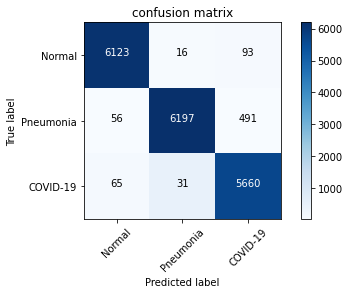

val_total Loss: 0.2106 Acc: 95.9855%
all_prediction:95.99
0 	 Normal 	 prediction= 98.25 %,	recall= 98.06 %,	f1= 98.15
1 	 Pneumonia 	 prediction= 91.89 %,	recall= 99.25 %,	f1= 95.43
2 	 COVID-19 	 prediction= 98.33 %,	recall= 90.65 %,	f1= 94.33
MACRO-averaged:
prediction= 96.16 %,recall= 95.99 %,f1= 96.07
----------------------------------------------------------------------------------------------------
Epoch 16/19
train iteration:99,loss:0.00142524519469589,acc:100.0%
train iteration:199,loss:0.034477002918720245,acc:98.4375%
train iteration:299,loss:0.0003781695559155196,acc:100.0%
train iteration:399,loss:0.00013480515917763114,acc:100.0%
train iteration:499,loss:0.00010048537660622969,acc:100.0%
train iteration:599,loss:0.002603252651169896,acc:100.0%
train iteration:699,loss:9.912242967402562e-05,acc:100.0%
train iteration:799,loss:0.04591620713472366,acc:96.875%
train iteration:899,loss:0.00019525992684066296,acc:100.0%
train iteration:999,loss:0.0007367553771473467,acc:100.0%


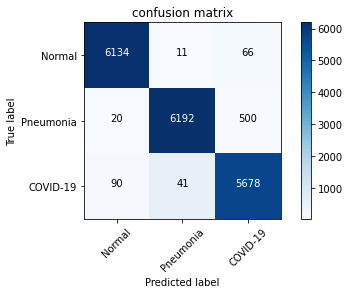

val_total Loss: 0.2613 Acc: 96.1136%
all_prediction:96.11
0 	 Normal 	 prediction= 98.76 %,	recall= 98.24 %,	f1= 98.5
1 	 Pneumonia 	 prediction= 92.25 %,	recall= 99.17 %,	f1= 95.58
2 	 COVID-19 	 prediction= 97.74 %,	recall= 90.94 %,	f1= 94.22
MACRO-averaged:
prediction= 96.25 %,recall= 96.12 %,f1= 96.18
----------------------------------------------------------------------------------------------------
Epoch 17/19
train iteration:99,loss:0.0016928361728787422,acc:100.0%
train iteration:199,loss:0.001369295408949256,acc:100.0%
train iteration:299,loss:0.0017936298390850425,acc:100.0%
train iteration:399,loss:0.0012751633767038584,acc:100.0%
train iteration:499,loss:0.0060509610921144485,acc:100.0%
train iteration:599,loss:0.013522648252546787,acc:100.0%
train iteration:699,loss:0.00219072587788105,acc:100.0%
train iteration:799,loss:0.010188287124037743,acc:100.0%
train iteration:899,loss:0.00196529901586473,acc:100.0%
train iteration:999,loss:0.00030841602711007,acc:100.0%
train iter

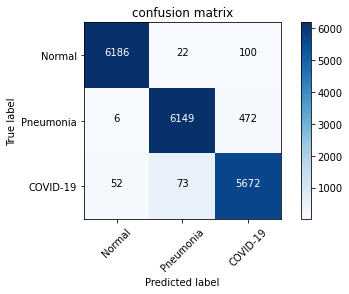

val_total Loss: 0.2297 Acc: 96.1296%
all_prediction:96.13
0 	 Normal 	 prediction= 98.07 %,	recall= 99.07 %,	f1= 98.57
1 	 Pneumonia 	 prediction= 92.79 %,	recall= 98.48 %,	f1= 95.55
2 	 COVID-19 	 prediction= 97.84 %,	recall= 90.84 %,	f1= 94.21
MACRO-averaged:
prediction= 96.23 %,recall= 96.13 %,f1= 96.18
----------------------------------------------------------------------------------------------------
Epoch 18/19
train iteration:99,loss:0.007465843111276627,acc:100.0%
train iteration:199,loss:0.022102996706962585,acc:98.4375%
train iteration:299,loss:0.01254762802273035,acc:98.4375%
train iteration:399,loss:0.0005444837152026594,acc:100.0%
train iteration:499,loss:0.00788490567356348,acc:100.0%
train iteration:599,loss:0.00030160759342834353,acc:100.0%
train iteration:699,loss:0.0010557945352047682,acc:100.0%
train iteration:799,loss:0.0027615372091531754,acc:100.0%
train iteration:899,loss:0.0010665279114618897,acc:100.0%
train iteration:999,loss:0.00143111078068614,acc:100.0%
tra

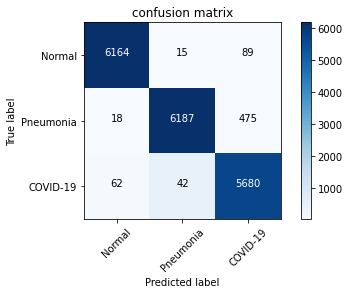

val_total Loss: 0.2156 Acc: 96.2577%
all_prediction:96.26
0 	 Normal 	 prediction= 98.34 %,	recall= 98.72 %,	f1= 98.53
1 	 Pneumonia 	 prediction= 92.62 %,	recall= 99.09 %,	f1= 95.75
2 	 COVID-19 	 prediction= 98.2 %,	recall= 90.97 %,	f1= 94.45
MACRO-averaged:
prediction= 96.39 %,recall= 96.26 %,f1= 96.32
----------------------------------------------------------------------------------------------------
Epoch 19/19
train iteration:99,loss:0.004876343067735434,acc:100.0%
train iteration:199,loss:0.00034473344567231834,acc:100.0%
train iteration:299,loss:0.0007592045585624874,acc:100.0%
train iteration:399,loss:0.0005547268665395677,acc:100.0%
train iteration:499,loss:0.007364433724433184,acc:100.0%
train iteration:599,loss:0.0025242401752620935,acc:100.0%
train iteration:699,loss:0.00011747045209631324,acc:100.0%
train iteration:799,loss:0.0008804442477412522,acc:100.0%
train iteration:899,loss:0.002810923382639885,acc:100.0%
train iteration:999,loss:0.0008191738743335009,acc:100.0%
tr

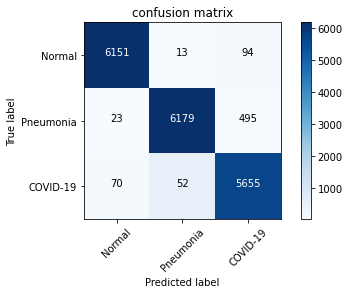

val_total Loss: 0.2637 Acc: 96.0122%
all_prediction:96.01
0 	 Normal 	 prediction= 98.29 %,	recall= 98.51 %,	f1= 98.4
1 	 Pneumonia 	 prediction= 92.27 %,	recall= 98.96 %,	f1= 95.5
2 	 COVID-19 	 prediction= 97.89 %,	recall= 90.57 %,	f1= 94.09
MACRO-averaged:
prediction= 96.15 %,recall= 96.01 %,f1= 96.08
****************************************************************************************************
best_acc:0.9677023275677984
****************************************************************************************************


In [24]:
if __name__ == '__main__':
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    acc=[]
    for epoch in range(num_epochs):
        train(model,epoch,num_epochs,criterion,optimizer)
        best_model_wts,best_acc,epoch_acc=test(model,epoch,num_epochs,criterion,optimizer,best_acc)
        acc.append(epoch_acc)
    print('*' * 100)
    print('best_acc:{}'.format(best_acc))
    print('*' * 100)
    torch.save(best_model_wts, 'densenet201_3_model_best_acc.pth')

In [25]:
# acc1=[]
# for i in acc:
#     acc1.append(round(i.item(),3))
# print('准确率最大：{}'.format(max(acc1)))
print(acc)

[0.9436258808456117, 0.9572923339739483, 0.9625774076446721, 0.9677023275677984, 0.9577194106342088, 0.9602284860132394, 0.9585201793721972, 0.9589472560324578, 0.9594277172752509, 0.9602284860132394, 0.9655135596839632, 0.9568652573136878, 0.9657270980140935, 0.9618834080717489, 0.9629510997224001, 0.9598547939355114, 0.9611360239162929, 0.9612961776638906, 0.9625774076446721, 0.9601217168481743]


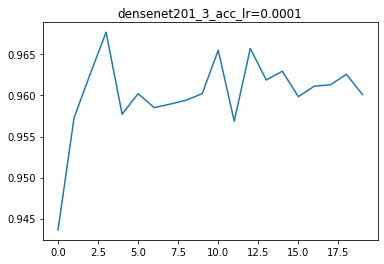

In [26]:
x=range(len(acc))
y=acc
plt.figure()
plt.title('densenet201_3_acc_lr=0.0001')
plt.plot(x,y)
plt.savefig('mini64_lr0.0001_e20_densenet201_3_acc.jpg')
plt.show()